### Inicialização (fazendo o arquivo se encotrar no repositorio)

Normalmente uso um repositório contendo material de várias diferentes cadeiras nesse caso as seguintes linhas servem para que todos os importes possam ser encontrados adequadamente.

In [1]:
import sys
import os

# Obtém o caminho do diretório do script atual
script_dir = os.getcwd()

# Adiciona o diretório pai ao caminho do sistema
sys.path.append(script_dir)

### Importando bibliotecas necessárias

In [2]:
import pygame # Nos repositórios de referência essa lib é sempre importada tendo em vista que o gymnasium (gym) utiliza a mesma, deve evitar problemas

import time # será utilizada para coletar o período temporal necessário para que algumas funções sejam executadas
from datetime import datetime

import numpy as np # numpy por motivos óbvios  

import torch # Todas as redes neurais serão criados utilizando PyTorch
import torch.nn as nn
import torch.optim as optim


import matplotlib.pyplot as plt # Demonstração de Gráficos e imagens 

pygame 2.3.0 (SDL 2.24.2, Python 3.11.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML, display, clear_output

Importando módulos próprios:

1 - importando os módulos DQN e de edição de imagens (Para caber a proposta da atividade)

2 - import de auxiliares do DQN (buffer, escolha de ação, função de perda)

3 -  import do gymnasium como gym (biblioteca contendo os ambientes usados)

4 - inicializando o PyTorch CPU ou GPU caso a mesma esteja disponível 


In [4]:
from modelos import dqn_models
from wrappers.atari_wrappers import *
from DQN_aux.DQN_aux import *

import gymnasium as gym

# verifica a disponibilidade da GPU
if torch.cuda.is_available():
    is_gpu = torch.device("cuda")
else:
    is_gpu = torch.device("cpu")

torch.set_default_device(is_gpu) # instanciando onde a rede neural deve rodar 

## definição de algumas funções importantes

#### Definição da função que salva vídeos com uma rede neural previamente treinada ou de forma aleatória (epsilon = 1.0 para aleatoriedade total).

In [5]:
# Baseada na minha versão (Pablo)
def record_video_q_neuralnet(env_name, qnet, episodes=3, folder='videos/', prefix='rl-video', epsilon=0.0):
    """
    Grava um vídeo a partir de uma política epsilon-greedy definida pela 'qtable' e pelo valor de 'epsilon'.
    - env_name: A string do ambiente cadastrada no gymnasium ou uma instância da classe. Ao final, o ambiente é fechado (função `close()`).
    - qnet: A rede neural que representa a função Q.
    - episodes: Número de episódios completos que serão executados.
    - prefiz: Prefixo do nome dos arquivos de vídeo.
    - folder: Pasta onde os arquivos de vídeo serão salvos.
    - epsilon: Valor do parâmetro da política "epsilon-greedy" usada para escolher as ações.
    """
    if isinstance(env_name, str):
        env = gym.make(env_name, render_mode="rgb_array")
    else:
        env = env_name
    rec_env = gym.wrappers.RecordVideo(env, folder, episode_trigger=lambda i : True, name_prefix=prefix)
    num_steps = 0
    for epi in range(episodes):
        state, _ = rec_env.reset()
        num_steps += 1
        epi_reward = 0.0
        done = False
        while not done:
            action = choose_action(qnet, env, state, epsilon)
            state, r, termi, trunc, _ = rec_env.step(action)
            done = termi or trunc
            num_steps += 1
            epi_reward += r
        print(f"Episode {epi}: {num_steps} steps / return {epi_reward:.2f}")
    rec_env.close()
    env.close()

### Função de treinamento DQN!

In [6]:
def DQN_TRAIN(env, env_name, gamma, qnet, qnet_lr, target_qnet, target_update_freq, replay_size, batch_size, epsilon_f, epsilon_decay_period, NUM_STAPS):

    """
    Treina um agente utilizando o algoritmo Deep Q-Network (DQN) em um ambiente de aprendizado por reforço.

    Args:
        env: O ambiente de aprendizado por reforço. Pode ser uma instância da classe do ambiente ou uma string 
            que representa o nome do ambiente registrado no Gym.
        env_name (str): O nome do ambiente (usado para fins de logging e salvamento).
        gamma (float): O fator de desconto para recompensas futuras.
        qnet (torch.nn.Module): A rede neural que representa a função Q.
        qnet_lr (float): A taxa de aprendizado para o otimizador Adam utilizado para treinar a rede neural.
        target_qnet (torch.nn.Module): A rede neural que representa a função Q-alvo.
        target_update_freq (int): A frequência com que os pesos da rede alvo são atualizados.
        replay_size (int): O tamanho do buffer de experiência usado para amostragem durante o treinamento.
        batch_size (int): O tamanho do lote usado para atualizar os pesos da rede neural.
        epsilon_f (float): O valor inicial de epsilon para a política epsilon-greedy.
        epsilon_decay_period (int): O período de decaimento para o valor de epsilon.
        NUM_STAPS (int): O número total de passos de treinamento a serem executados.
    """

    # Cria o otimizador, que vai fazer o ajuste dos pesos da 'qnet',
    # Usa uma técnica de gradiente descendente de destaque, chamada ADAM
    optimizer = optim.Adam(qnet.parameters(), lr=qnet_lr)

    # Para o logging de dados, para serem exibidos no tensorboard
    writer = SummaryWriter(comment="-" + env_name)

    buffer = DQNExperienceBuffer(replay_size)

    start_time_str = datetime.now().strftime("%Y-%m-%d,%H-%M-%S")
    episode_reward_list = []
    step = 0
    epsilon = 1.0

    state, _ = env.reset()
    episode_reward = 0.0
    episode_start_step = 0
    episode_start_time = time.time()

    while True:
        step += 1

        # Decaimento linear do epsilon
        epsilon = max(epsilon_f, 1.0 - step / epsilon_decay_period)

        action = choose_action(qnet, env, state, epsilon)

        # Faz um passo / Aplica uma ação no ambiente
        new_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        # Adiciona no buffer
        buffer.append(state, action, reward, terminated, new_state)
        state = new_state

        if done:
            episode_reward_list.append(episode_reward)
            speed = (step - episode_start_step) / (time.time() - episode_start_time + 0.00001)

            state, _ = env.reset()
            episode_reward = 0.0
            episode_start_step = step
            episode_start_time = time.time()

            # Abaixo, faz vários loggings de dados
            mean_reward = np.mean(episode_reward_list[-100:])
            print(f"{step}: finished {len(episode_reward_list)} episodes, mean reward {mean_reward:.3f}, eps {epsilon:.2f}, speed {speed:.2f} steps/s")
            writer.add_scalar("epsilon", epsilon, step)
            writer.add_scalar("epi_reward_100", mean_reward, step)
            writer.add_scalar("epi_reward", episode_reward, step)

            # Testa se "resolveu" o ambiente
            if step > NUM_STAPS:
                print(f"Solved in {step} steps with mean reward {mean_reward:.3f}")
                # Verifica se o diretório existe e, se não, cria-o
                model_dir = 'models/' + env_name
                if not os.path.exists(model_dir):
                    os.makedirs(model_dir)
                filename = model_dir + "-" + start_time_str + ".dat"
                torch.save(qnet.state_dict(), filename)
                print(f"Model saved as {filename}") 
                break

        if len(buffer) < replay_size:
            continue

        # Faz a 'tgt_net' receber os mesmos valores de pesos da 'qnet', na frequência indicada
        if step % target_update_freq == 0:
            target_qnet.load_state_dict(qnet.state_dict())

        # Escolhendo amostras aleatórios do buffer e faz uma atualização dos pesos da rede
        optimizer.zero_grad()
        batch = buffer.sample(batch_size)
        loss_t = calc_loss(batch, qnet, target_qnet, gamma)
        loss_t.backward()
        optimizer.step()

    writer.close()
    return episode_reward_list

In [7]:
def display_videos_from_path(video_folder='', prefix='rl-video', speed=1.0):
    """
    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) To filter the video files
    """
    html = []
    for mp4 in Path(video_folder).glob("{}*.mp4".format(prefix)):
        video_b64 = b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                    </video>'''.format(mp4, video_b64.decode('ascii')))
    display(HTML(data="<br>".join(html)))
    
    # Add JavaScript code to set playback speed
    display(HTML(f'''
        <script>
        var videos = document.getElementsByTagName('video');
        for (var i = 0; i < videos.length; i++) {{
            videos[i].playbackRate = {speed};
        }}
        </script>
        '''))

### Agora vamos definir os valores de entrada para o treinamento e inicializa o ambiente (env)

In [10]:
ATARI_ENV_NAME = "ALE/SpaceInvaders-v5"

NUM_STAPS = 1_200_000 # numero de passos desejados (1000000) 

# Parâmetros do DQN
GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 20_000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1_500

EPSILON_DECAY_PERIOD = 100_000
EPSILON_FINAL = 0.02

N_STAPS_FOR_OBS = 4 # número de passos que geram um "Estado"

env = gym.make(ATARI_ENV_NAME)

### aplicando os wrappers como Start, recorte, redução de 3 para 1 canal

In [11]:
# Aplica os wrappers do DQN para ambientes Atari
enva = MaxAndSkipEnv(env)
envb = FireResetEnv(enva)
envc = ProcessFrame84(envb)
envd = ImageToPyTorch(envc)
enve = BufferWrapper(envd, N_STAPS_FOR_OBS)
envf = ScaledFloatFrame(enve)

### inicializa as redes neurais via PyTorch

In [12]:
# Cria as redes neurais
qnet = dqn_models.DQNNet(envf.observation_space.shape, envf.action_space.n)
qtarget = dqn_models.DQNNet(envf.observation_space.shape, envf.action_space.n)

### Demonstrando o resultade de alguns wrappers

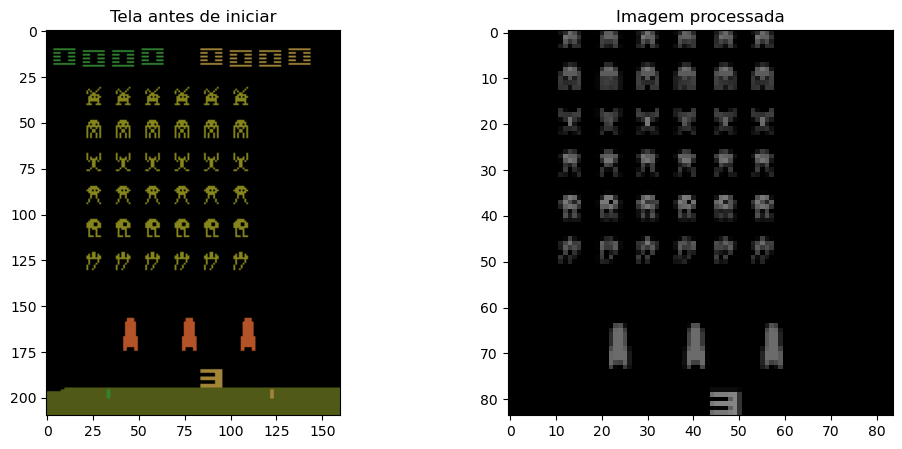

In [19]:
# Mostrando a tela do ambiente original, e outras telas após passar por alguns wrappers
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

s, _ = env.reset()
ax1.imshow(s)
ax1.set_title('Tela antes de iniciar')

s, _ = envd.reset()
ax2.imshow(s[0], cmap='gray', vmin=0, vmax=255)  # exibe em escala de cinza
ax2.set_title('Imagem processada');

### Realiza o treinamento utilizando os valores oferecidos anteriormente

In [101]:
inicio = time.time()

lisat_fim = DQN_TRAIN(
    env = envf,
    env_name = ATARI_ENV_NAME,
    gamma = GAMMA,
    qnet = qnet,
    qnet_lr = LEARNING_RATE,
    target_qnet = qtarget,
    target_update_freq = SYNC_TARGET_FRAMES,
    replay_size = REPLAY_SIZE,
    batch_size = BATCH_SIZE,
    epsilon_f = EPSILON_FINAL,
    epsilon_decay_period = EPSILON_DECAY_PERIOD,
    NUM_STAPS = NUM_STAPS)

fim = time.time()

Tempo_total = fim - inicio

106: finished 1 episodes, mean reward 95.000, eps 1.00, speed 303.46 steps/s
218: finished 2 episodes, mean reward 87.500, eps 1.00, speed 277.91 steps/s
320: finished 3 episodes, mean reward 105.000, eps 1.00, speed 274.92 steps/s
384: finished 4 episodes, mean reward 92.500, eps 1.00, speed 292.21 steps/s
502: finished 5 episodes, mean reward 96.000, eps 0.99, speed 270.64 steps/s
616: finished 6 episodes, mean reward 95.833, eps 0.99, speed 280.78 steps/s
738: finished 7 episodes, mean reward 92.143, eps 0.99, speed 306.81 steps/s
805: finished 8 episodes, mean reward 83.125, eps 0.99, speed 313.07 steps/s
880: finished 9 episodes, mean reward 78.333, eps 0.99, speed 314.83 steps/s
1030: finished 10 episodes, mean reward 86.500, eps 0.99, speed 319.12 steps/s
1130: finished 11 episodes, mean reward 84.091, eps 0.99, speed 313.41 steps/s
1248: finished 12 episodes, mean reward 80.833, eps 0.99, speed 301.80 steps/s
1377: finished 13 episodes, mean reward 80.769, eps 0.99, speed 306.8

### grafico de demonstra a evolução do aprendizado

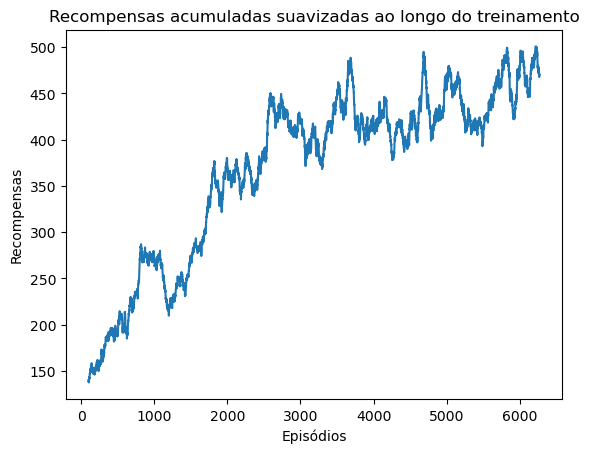

In [102]:
# Calculando a média móvel com uma janela de 100 episódios
janela = 100 # Suaviza as varianças para facilitar a leitura
#janela = 1 # Descomente para remover a suavisação

recompensas_suavizadas = np.convolve(lisat_fim, np.ones(janela)/janela, mode='valid')

# Criando uma lista de episódios para o eixo x
episodios = list(range(janela, janela + len(recompensas_suavizadas)))

# Plotando o gráfico das recompensas suavizadas ao longo do tempo
plt.plot(episodios, recompensas_suavizadas)
plt.title('Recompensas acumuladas suavizadas ao longo do treinamento')
plt.xlabel('Episódios')
plt.ylabel('Recompensas')
plt.show()

In [13]:
# Para carregar uma rede salva de arquivo, descomente o bloco abaixo
# Essa rede salva pode ser testada ou treinada por mais alguns passos

filename = "models/ALE/" + "SpaceInvaders-v5-2024-02-17,03-20-49.dat"
qnet.load_state_dict(torch.load(filename, map_location=lambda storage,loc: storage))

<All keys matched successfully>

Gravando uma pratida pos treinamento com 1_200_000 passos

In [14]:
# Roda alguns episódigos com o modelo e salva os vídeos em arquivos
# Atenção: precisa rodar com os wrappers aplicados!
env2 = gym.make(ATARI_ENV_NAME, render_mode="rgb_array")
env2a = MaxAndSkipEnv(env2)
env2b = FireResetEnv(env2a)
env2c = ProcessFrame84(env2b)
env2d = ImageToPyTorch(env2c)
env2e = BufferWrapper(env2d, 4)
env2f = ScaledFloatFrame(env2e)

record_video_q_neuralnet(env2f, qnet, episodes=1, folder="./dqn-atari")

c:\Users\Pichau\anaconda3\envs\rl23\Lib\site-packages\gymnasium\wrappers\record_video.py:87: UserWarning: WARN: Overwriting existing videos at c:\Users\Pichau\Desktop\Faculdade\Projects\Facul Repositorios\Repositorios_Universitarios\Aprendizagem por Refoco\Projeto_Atari\dqn-atari folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
c:\Users\Pichau\anaconda3\envs\rl23\Lib\site-packages\gymnasium\utils\passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Moviepy - Building video c:\Users\Pichau\Desktop\Faculdade\Projects\Facul Repositorios\Repositorios_Universitarios\Aprendizagem por Refoco\Projeto_Atari\dqn-atari\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\Pichau\Desktop\Faculdade\Projects\Facul Repositorios\Repositorios_Universitarios\Aprendizagem por Refoco\Projeto_Atari\dqn-atari\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Pichau\Desktop\Faculdade\Projects\Facul Repositorios\Repositorios_Universitarios\Aprendizagem por Refoco\Projeto_Atari\dqn-atari\rl-video-episode-0.mp4
Episode 0: 290 steps / return 690.00


In [16]:
display_videos_from_path('./dqn-atari')